In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.autograd as autograd

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import sys
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class FrontEnd(nn.Module):
  ''' front end part of discriminator and Q'''

  def __init__(self):
    super(FrontEnd, self).__init__()

    self.main = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Conv2d(64, 128, 4, 2, 1, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Conv2d(128, 1024, 7, bias=False),
      nn.BatchNorm2d(1024),
      nn.LeakyReLU(0.1, inplace=True),
    )

  def forward(self, x):
    output = self.main(x)
    return output


class D(nn.Module):

  def __init__(self):
    super(D, self).__init__()
    
    self.main = nn.Sequential(
      nn.Conv2d(1024, 1, 1),
      nn.Sigmoid()
    )
    

  def forward(self, x):
    output = self.main(x).view(-1, 1)
    return output


class Q(nn.Module):

  def __init__(self):
    super(Q, self).__init__()

    self.conv = nn.Conv2d(1024, 128, 1, bias=False)
    self.bn = nn.BatchNorm2d(128)
    self.lReLU = nn.LeakyReLU(0.1, inplace=True)
    self.conv_disc = nn.Conv2d(128, 10, 1)
    self.conv_mu = nn.Conv2d(128, 2, 1)
    self.conv_var = nn.Conv2d(128, 2, 1)

  def forward(self, x):

    y = self.conv(x)

    disc_logits = self.conv_disc(y).squeeze()

    mu = self.conv_mu(y).squeeze()
    var = self.conv_var(y).squeeze().exp()

    return disc_logits, mu, var 


class G(nn.Module):

  def __init__(self):
    super(G, self).__init__()

    self.main = nn.Sequential(
      nn.ConvTranspose2d(74, 1024, 1, 1, bias=False),
      nn.BatchNorm2d(1024),
      nn.ReLU(True),
      nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
      nn.BatchNorm2d(128),
      nn.ReLU(True),
      nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(True),
      nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
      nn.Sigmoid()
    )

  def forward(self, x):
    output = self.main(x)
    return output

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
class log_gaussian:

  def __call__(self, x, mu, var):

    logli = -0.5*(var.mul(2*np.pi)+1e-6).log() - \
            (x-mu).pow(2).div(var.mul(2.0)+1e-6)
    
    return logli.sum(1).mean().mul(-1)

class Trainer:

  def __init__(self, G, FE, D, Q):

    self.G = G
    self.FE = FE
    self.D = D
    self.Q = Q

    self.batch_size = 100

  def _noise_sample(self, dis_c, con_c, noise, bs):

    idx = np.random.randint(10, size=bs)
    c = np.zeros((bs, 10))
    c[range(bs),idx] = 1.0

    dis_c.data.copy_(torch.Tensor(c))
    con_c.data.uniform_(-1.0, 1.0)
    noise.data.uniform_(-1.0, 1.0)
    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)

    return z, idx

  def train(self):

    real_x = torch.FloatTensor(self.batch_size, 1, 28, 28).cuda()
    label = torch.FloatTensor(self.batch_size, 1).cuda()
    dis_c = torch.FloatTensor(self.batch_size, 10).cuda()
    con_c = torch.FloatTensor(self.batch_size, 2).cuda()
    noise = torch.FloatTensor(self.batch_size, 62).cuda()

    real_x = Variable(real_x)
    label = Variable(label, requires_grad=False)
    dis_c = Variable(dis_c)
    con_c = Variable(con_c)
    noise = Variable(noise)

    criterionD = nn.BCELoss().cuda()
    criterionQ_dis = nn.CrossEntropyLoss().cuda()
    criterionQ_con = log_gaussian()

    optimD = optim.Adam([{'params':self.FE.parameters()}, {'params':self.D.parameters()}], lr=0.0002, betas=(0.5, 0.99))
    optimG = optim.Adam([{'params':self.G.parameters()}, {'params':self.Q.parameters()}], lr=0.001, betas=(0.5, 0.99))

    dataset = dset.MNIST('./dataset', transform=transforms.ToTensor(), download=True)
    dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=1)

    # fixed random variables
    c = np.linspace(-1, 1, 10).reshape(1, -1)
    c = np.repeat(c, 10, 0).reshape(-1, 1)

    c1 = np.hstack([c, np.zeros_like(c)])
    c2 = np.hstack([np.zeros_like(c), c])

    idx = np.arange(10).repeat(10)
    one_hot = np.zeros((100, 10))
    one_hot[range(100), idx] = 1
    fix_noise = torch.Tensor(100, 62).uniform_(-1, 1)


    for epoch in range(100):
      for n_i, batch_data in enumerate(dataloader, 0):

        # real part
        optimD.zero_grad()
        
        x, _ = batch_data

        bs = x.size(0)
        real_x.data.resize_(x.size())
        label.data.resize_(bs, 1)
        dis_c.data.resize_(bs, 10)
        con_c.data.resize_(bs, 2)
        noise.data.resize_(bs, 62)
        
        real_x.data.copy_(x)
        fe_out1 = self.FE(real_x)
        probs_real = self.D(fe_out1)
        label.data.fill_(1)
        loss_real = criterionD(probs_real, label)
        loss_real.backward()

        # fake part
        z, idx = self._noise_sample(dis_c, con_c, noise, bs)
        fake_x = self.G(z)
        fe_out2 = self.FE(fake_x.detach())
        probs_fake = self.D(fe_out2)
        label.data.fill_(0)
        loss_fake = criterionD(probs_fake, label)
        loss_fake.backward()

        discriminator_loss = loss_real + loss_fake

        optimD.step()
        
        # G and Q part
        optimG.zero_grad()

        fe_out = self.FE(fake_x)
        probs_fake = self.D(fe_out)
        label.data.fill_(1.0)

        reconstruct_loss = criterionD(probs_fake, label)
        
        q_logits, q_mu, q_var = self.Q(fe_out)
        class_ = torch.LongTensor(idx).cuda()
        target = Variable(class_)
        dis_loss = criterionQ_dis(q_logits, target)
        con_loss = criterionQ_con(con_c, q_mu, q_var)*0.1
        
        generator_loss = reconstruct_loss + dis_loss + con_loss
        generator_loss.backward()
        optimG.step()

        if n_i % 100 == 0:

            sys.stdout.write('Epoch/Iter:{0}/{1}, D_Loss: {2}, G_Loss: {3}\r'.format(
                epoch + 1, n_i, discriminator_loss.item(), generator_loss.item())
            )
            sys.stdout.flush()
    print('')

In [14]:
fe = FrontEnd()
d = D()
q = Q()
g = G()

for i in [fe, d, q, g]:
  i.cuda()
  i.apply(weights_init)

trainer = Trainer(g, fe, d, q)
trainer.train()

Epoch/Iter:100/500, D_Loss: 0.20044687390327454, G_Loss: 4.173387527465825


In [15]:
torch.save(g.state_dict(), 'mnist_info_gan_gen')
torch.save(d.state_dict(), 'mnist_info_gan_dsc')

torch.save(fe.state_dict(), 'mnist_info_gan_fe')
torch.save(q.state_dict(),  'mnist_info_gan_q')

In [26]:
idx = np.arange(10).repeat(10)
one_hot = np.zeros((100, 10))
one_hot[range(100), idx] = 1
    
fix_noise = torch.Tensor(100, 62).uniform_(-1, 1).cuda()
dis_c = torch.FloatTensor(100, 10).cuda()
dis_c.data.copy_(torch.Tensor(one_hot))

c = np.linspace(-1, 1, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)
c1 = np.hstack([c, np.zeros_like(c)])
c2 = np.hstack([np.zeros_like(c), c])
    
con_c = torch.FloatTensor(100, 2).cuda()
con_c.data.copy_(torch.from_numpy(c1))
z = torch.cat([fix_noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
x_save_c1 = g(z)

con_c.data.copy_(torch.from_numpy(c2))
z = torch.cat([fix_noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
x_save_c2 = g(z)

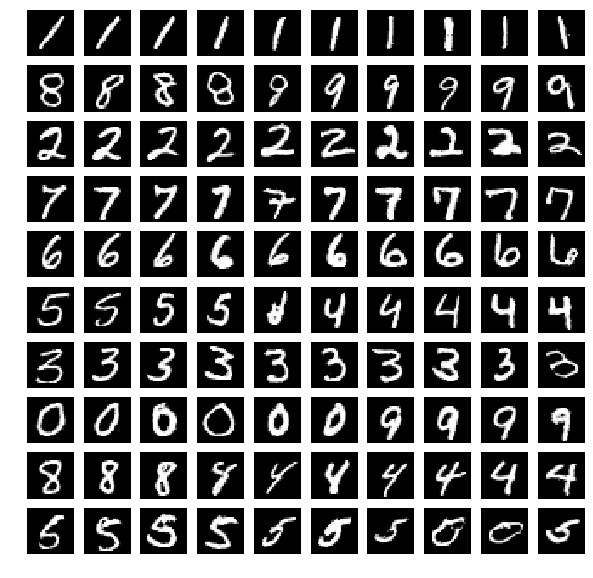

In [45]:
nimg = 10
f, ax = plt.subplots(10,10, figsize=(10,10))
for i in range(nimg):
    for j in range(nimg):
        ax[i][j].imshow(x_save_c1.data.cpu()[i*nimg + j][0], cmap='gray')
        ax[i][j].axis('off')

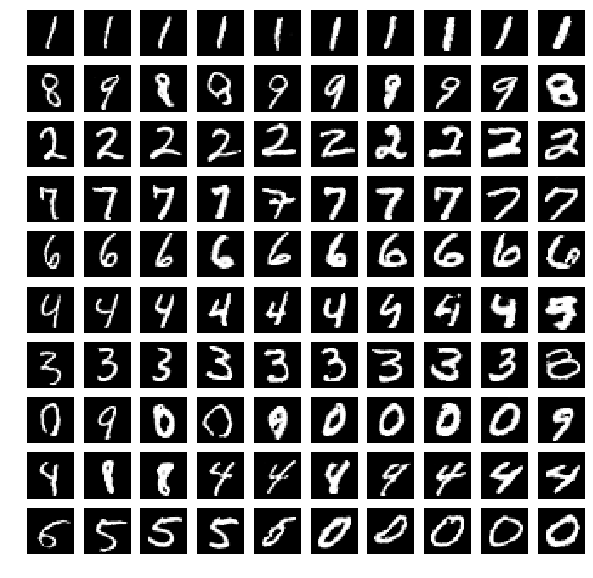

In [46]:
nimg = 10
f, ax = plt.subplots(10,10, figsize=(10,10))
for i in range(nimg):
    for j in range(nimg):
        ax[i][j].imshow(x_save_c2.data.cpu()[i*nimg + j][0], cmap='gray')
        ax[i][j].axis('off')